## 1. Carga de datos

   Tiempo (ms)     IR  AMB_IR    RED  AMB_RED
0            0      0       0  28079        0
1           16  46038   11857  29800    11838
2           33  46188   11938  29966    11922
3           50  46308   12005  30112    11990
4           66  46407   12044  30269    12034


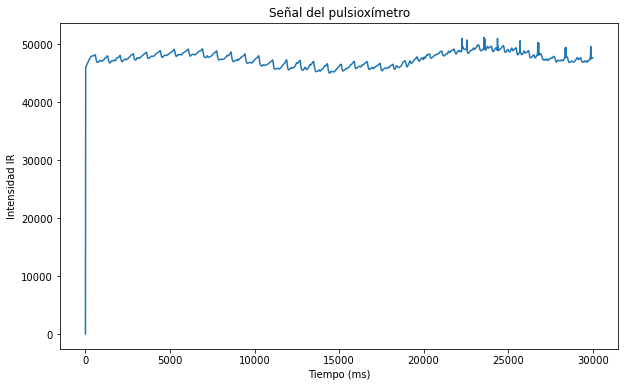

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV
ruta_csv = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_80.csv"
df = pd.read_csv(ruta_csv, delimiter=";")

# Mostrar las primeras filas
print(df.head())

# Graficar la señal IR para ver su forma
plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"])
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad IR")
plt.title("Señal del pulsioxímetro")
plt.show()


## 2. Preprocesamiento de la señal


Antes de detectar los picos de la señal hay que suavizar la señal, eliminar el ruido y los artefactos que pueda haber. 

### Filtrado con media móvil (simple)

In [69]:
# df["IR_filtrado"] = df["IR"].rolling(window=5, center=True).mean()

# plt.figure(figsize=(10,6))
# plt.plot(df["Tiempo (ms)"], df["IR"], label="Original", alpha=0.5)
# plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Filtrado", linewidth=2)
# plt.legend()
# plt.title("Señal IR filtrada")
# plt.show()


## Filtro Butterworth

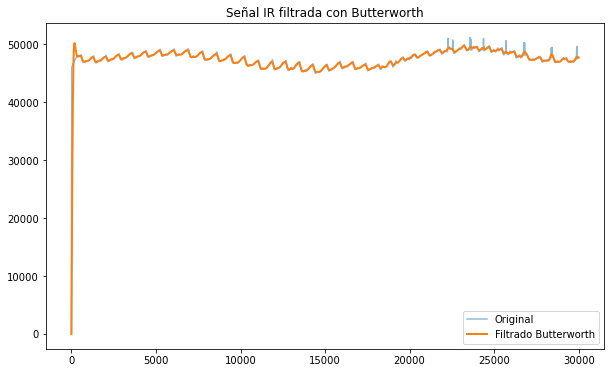

In [70]:
from scipy.signal import butter, filtfilt

# Función para aplicar un filtro pasa-bajos
def butter_lowpass_filter(data, cutoff=3, fs=35, order=2):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

df["IR_filtrado"] = butter_lowpass_filter(df["IR"], cutoff=3, fs=60)

plt.figure(figsize=(10,6))
plt.plot(df["Tiempo (ms)"], df["IR"], alpha=0.5, label="Original")
plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Filtrado Butterworth", linewidth=2)
plt.legend()
plt.title("Señal IR filtrada con Butterworth")
plt.show()


### 3. Detección de picos (latidos)
La frecuencia cardíaca se calcula detectando los picos de la señal filtrada, que corresponden a los latidos del corazón.

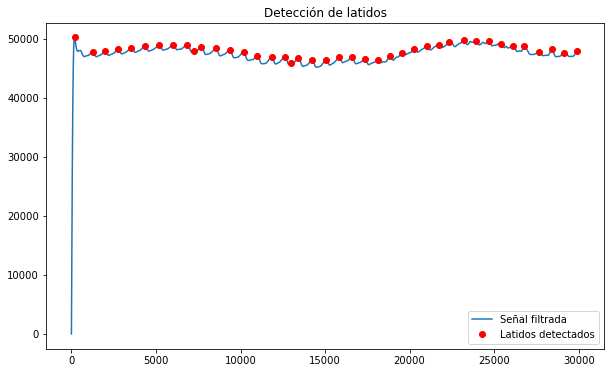

In [71]:
from scipy.signal import find_peaks

fs = 47  # Define la frecuencia de muestreo en Hz
        # Si deteccta pocos picos --> reducir fs
        # Si detecta muchos picos --
# Detectar los picos (latidos)
peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/2, height=0.5)  # Ajusta 'height' según la amplitud

# Graficar los picos detectados
plt.figure(figsize=(10,6))

plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Señal filtrada")
plt.plot(df["Tiempo (ms)"][peaks], df["IR_filtrado"][peaks], "ro", label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos")
plt.show()


## 4. Calcular la Frecuencia Cardíaca (BPM)
Ahora, calculamos el tiempo entre picos y lo convertimos en latidos por minuto (BPM).

In [66]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
bpm = 60 / np.mean(intervalos)
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")


Frecuencia cardíaca estimada: 82.79 BPM


La frecuencia calculada debería de ser de 80 BPM

Aunque la estimación está cerca de la frecuencia esperada, voy a ver si podemos acercarnos más al objetivo. 

**Ajuste del filtrado**\
El filtro Butterworth puede estar afectando la forma de la señal. Voy a probar un filtro de banda en lugar de un pasa-bajos para enfocarme solo en las frecuencias de interés (0.5-3 Hz, que corresponden a 30-180 BPM).

**Ajustar la detección de picos**\
Parece que find_peaks() detecta más picos de los esperados. Voy a ajustar los parámetros:

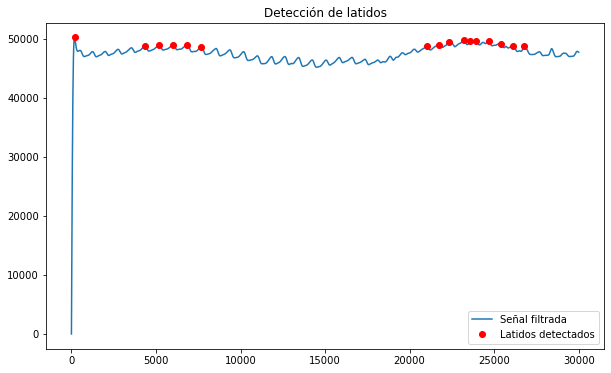

In [32]:
peaks, _ = find_peaks(df["IR_filtrado"], distance=fs/3, height=np.percentile(df["IR_filtrado"], 80))

plt.figure(figsize=(10,6))

plt.plot(df["Tiempo (ms)"], df["IR_filtrado"], label="Señal filtrada")
plt.plot(df["Tiempo (ms)"][peaks], df["IR_filtrado"][peaks], "ro", label="Latidos detectados")
plt.legend()
plt.title("Detección de latidos")
plt.show()


In [33]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
if len(intervalos) > 0:
    bpm = 60 / np.median(intervalos)  # Mediana en lugar de media
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")


Frecuencia cardíaca estimada: 80.00 BPM


- Si detecta más picos de la cuenta, reducir distance en find_peaks():
- Si detecta pocos picos, aumentar distance y height.

El parámetro distance en find_peaks() define la distancia mínima entre picos (en número de muestras), lo que ayuda a evitar detecciones falsas. Para encontrar un valor óptimo, se puede calcular basandose en la frecuencia esperada de los latidos.

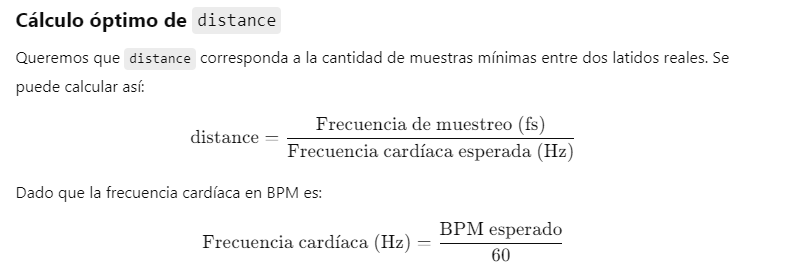

In [72]:
tiempos = np.diff(df["Tiempo (ms)"]) / 1000  # Diferencia entre cada muestra en segundos
fs_real = 1 / np.mean(tiempos)  # Frecuencia de muestreo real
print(f"Frecuencia de muestreo real: {fs_real:.2f} Hz")


Frecuencia de muestreo real: 60.04 Hz


In [ ]:
bpm_esperado = 80  # Frecuencia cardíaca esperada en BPM
fs_real = 60  # Asegúrate de calcular fs_real antes si puede variar

distance_optimo = fs_real / (bpm_esperado / 60)
print(f"Valor óptimo de distance: {distance_optimo:.2f}")


In [ ]:
peaks, _ = find_peaks(df["IR_filtrado"], distance=distance_optimo, height=np.percentile(df["IR_filtrado"], 75))


In [ ]:
import numpy as np

# Calcular los intervalos entre picos en segundos
intervalos = np.diff(df["Tiempo (ms)"][peaks]) / 1000  # Convertir ms a s

# Calcular BPM promedio
if len(intervalos) > 0:
    bpm = 60 / np.median(intervalos)  # Mediana en lugar de media
print(f"Frecuencia cardíaca estimada: {bpm:.2f} BPM")
